
ARIMA 
Loading data... 

******************************************************************** 
 Plot Original Series


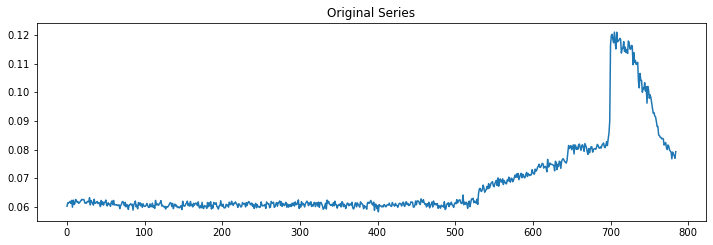


******************************************************************** 
 Plot Partial Autocorrelation


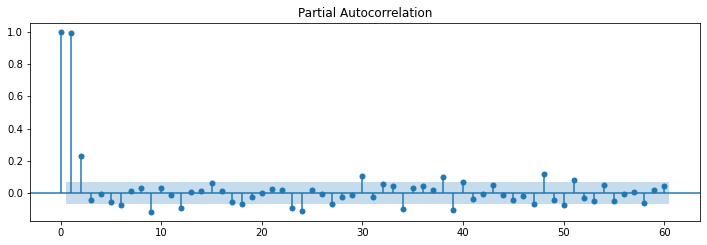


******************************************************************** 
 Plot Autocorrelation


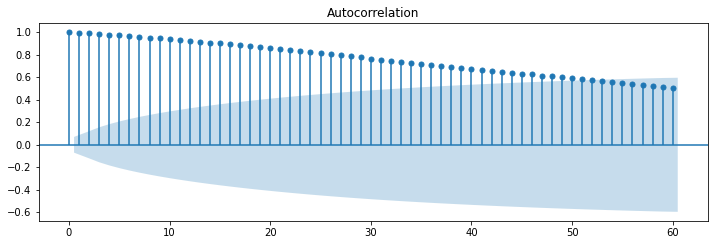

Normal ARIMA(1,0,50)                                                                                      
======================================================= ==================================================
Dependent Variable: Bearing1                            Method: PML                                       
Start Date: 835                                         Unnormalized Log Posterior: 388.2993              
End Date: 981                                           AIC: -670.5986                                    
Number of observations: 147                             BIC: -512.1057                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0388     0.0069     5.614    0.0      (0.0252 | 0.0523)        
AR(1)                                

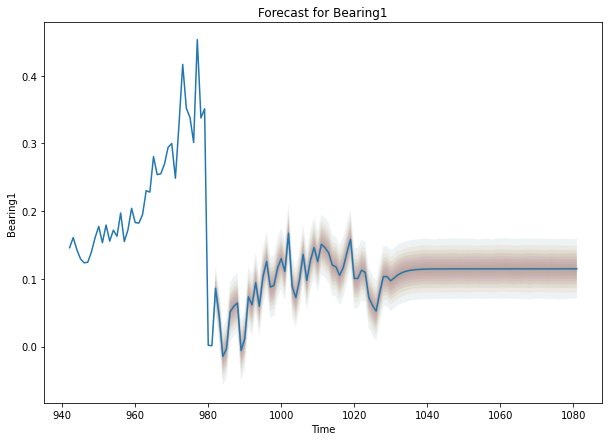

      Bearing1
982   0.086035
983   0.045200
984  -0.014516
985  -0.003289
986   0.051171
...        ...
1077  0.114727
1078  0.114727
1079  0.114727
1080  0.114727
1081  0.114727

[100 rows x 1 columns]
CPU utilization:  21.72 %
All dataset average:  0.081
Predicted dataset average:  0.104
All dataset st_deviation:  0.0402
Predicted dataset st_deviation:  0.0308
ARIMA TIME ---> 87.1s

LSTM 
Loading data... 

******************************************************************** 
Prepare data... 
Length of Data 982
Creating training data...
Training data shape  :  (684, 100)
Creating test data...
Test data shape  : (96, 100)
Shape X_train (684, 99)
Shape X_test (96, 99)
Shape X_train (684, 99, 1)
Shape X_test (96, 99, 1)

******************************************************************** 
Generate Model... 

******************************************************************** 
Training data... 
Training...
Epoch 1/40
9/9 [==============================] - 2s 230ms/step - loss: 0.4511 -

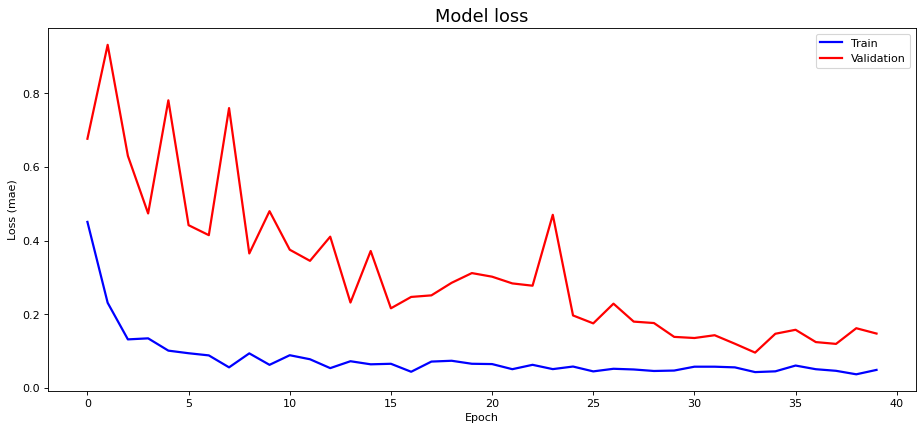


******************************************************************** 
Predicting...
Reshaping predicted
[-0.2812907  -0.278169   -0.27385408 -0.2686033  -0.25459433 -0.24115723
 -0.24467748 -0.2720008  -0.31936902 -0.3812474  -0.44891137 -0.51501423
 -0.57609254 -0.627537   -0.66789186 -0.69724804 -0.7125386  -0.7125826
 -0.6882651  -0.6323977  -0.5384667  -0.40113342 -0.22548498 -0.03188061
  0.15468273  0.29830918  0.37331215  0.4049127   0.41427886  0.40971017
  0.42771095  0.44262365  0.43182647  0.40672702  0.36234072  0.31910986
  0.274728    0.25607136  0.25861022  0.26488203  0.26681536  0.2453805
  0.19127944  0.13239738  0.10388128  0.10368975  0.145802    0.2424287
  0.39727837  0.6361376   1.0378268   1.3269675   1.450839    1.4511789
  1.3078015   1.0846424   0.85457593  0.642632    0.52295023  0.47779047
  0.5368681   0.60936487  0.6197091   0.55810666  0.4574335   0.38502795
  0.41816086  0.61822695  0.840215    1.140168    1.3491076   1.5267259
  1.6246326   1.8258586 

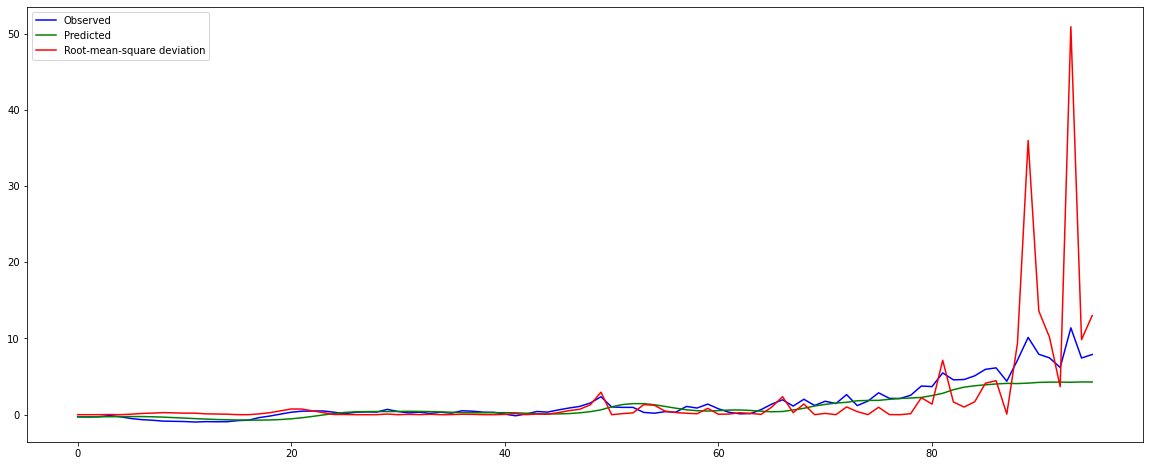

CPU utilization:  60.42 %
All dataset average:  0.081
Predicted dataset average:  0.9853
All dataset st_deviation:  0.0402
Predicted dataset st_deviation:  1.4887
LSTM TIME ---> 60.54s


In [1]:
from threading import Thread
from time import time, sleep
from statistics import mean, stdev
from psutil import cpu_percent
from pandas import read_csv, DataFrame
from termcolor import  colored
from modules import run_arima as ARIMA
from modules import run_lstm as LSTM


def exec_time(func, args:list) -> str:
    '''
    Function that measures execution time of a given function
    '''
    intiTime = time()
    try:
        func(*args)
    except Exception as e:
        print('ERROR: ',e)
    elapsedTime = round(time()-intiTime, 2)
    return str(elapsedTime)+'s'


def get_cpu_utilization() -> Thread:

    def cpu_util():
        cpu_data = []
        while(not IS_Process_end):
            sleep(1)
            cpu_data.append(cpu_percent())
        print('CPU utilization: ', round(mean(cpu_data),2),'%')

    return Thread(
        target=cpu_util
    )


def csv_to_df(csv_file:str) -> DataFrame:
    '''returns numpy array of values from a dataFrame)'''
    print('Loading data... ')
    df = read_csv(csv_file, parse_dates=[0], infer_datetime_format=True)
    return df


def run_arima(file:str, column:str):
    global IS_Process_end
    IS_Process_end = False
    df = csv_to_df(file)
    ARIMA_config = {
        'test_size': 0.2,
        'AR': 1,
        'MA': 50,
        'target_method': 'PML',
        'h': 100,
        'pv': 40
    }
    cpu_thread = get_cpu_utilization()
    cpu_thread.start()
    prediction = ARIMA.run(df, column, ARIMA_config)
    IS_Process_end = True
    cpu_thread.join()
    print('All dataset average: ', round(mean(df[column].tolist()),4))
    print('Predicted dataset average: ', round(mean(prediction),4))
    print('All dataset st_deviation: ', round(stdev(df[column].tolist()),4))
    print('Predicted dataset st_deviation: ',round(stdev(prediction),4))


def run_lstm(file:str, column:str):
    global IS_Process_end
    IS_Process_end = False
    df = csv_to_df(file)
    LSTM_config = {
        'test_size': 0.2,
        'is_normalized': True,
        'epochs': 40,
        'batch_size': 80,
        'validation_split': 0.05,
        'loss': 'mean_squared_error',
        'optimizer': 'rmsprop',
        'metrics': ['mean_absolute_percentage_error']
    }
    cpu_thread = get_cpu_utilization()
    cpu_thread.start()
    prediction = LSTM.run(df, column, LSTM_config)
    IS_Process_end = True
    cpu_thread.join()
    print('All dataset average: ', round(mean(df[column].tolist()),4))
    print('Predicted dataset average: ', round(mean(prediction),4))
    print('All dataset st_deviation: ', round(stdev(df[column].tolist()),4))
    print('Predicted dataset st_deviation: ',round(stdev(prediction),4))


def main():
    paths = {
        'vibration':['Averaged_BearingTest_Dataset.csv','Bearing1']
    }
    div = colored('\n===========================================','magenta')
    for solution in ['ARIMA','LSTM']:
        print(div,colored('\n'+solution,'magenta'),div)

        if solution == 'ARIMA':
            elapsedTime = exec_time(run_arima, args=paths['vibration'])
        elif solution == 'LSTM':
            elapsedTime = exec_time(run_lstm, args=paths['vibration'])

        print(solution,"TIME --->", elapsedTime)


main()
